Complete the exercises below For **Assignment #4**.

Use **Markdown** cells for the non-code answers.

In this assignment we will work with the data underlying the *FiveThirtyEight* article ["Higher Rates Of Hate Crimes Are Tied To Income Inequality"](https://fivethirtyeight.com/features/higher-rates-of-hate-crimes-are-tied-to-income-inequality/).

Load the `tidymodels`, `readr`, and `moderndive` packages in the cell below.

In [4]:
library('tidymodels')
library('readr')
install.packages("moderndive")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [5]:
library("moderndive")

We can read the data from a **CSV file** at the following URL: [http://bit.ly/2ItxYg3](http://bit.ly/2ItxYg3).

Use the `read_csv` function to read the data into our R session. Call the new table `hate_crimes`.

In [6]:
url <- "http://bit.ly/2ItxYg3"

In [7]:
hate_crimes <- read.csv(url)

Next, let’s add the high-school degree variable into the mix by creating a scatterplot showing:

- Income on the y-axis (this is the `income` variable)
- Percent of adults 25 or older with a high school degree on the x-axis (this is the `hs` variable)
- The points colored by level of urbanization in a region (this is the variable `urbanization`)


**In addition, add a line of best fit (regression line) for each level of the variable urbanization (one for “low”, one for “high”).**

*Add the regression lines to the plot using the `geom_parallel_slopes` function from the `moderndive` package. This function will draw the regression lines based on fitting a regression model with parallel slopes (i.e., with no interaction between `hs` and `urbanization`).*

Warning message:
“Removed 3 rows containing non-finite outside the scale range
(`stat_parallel_slopes()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


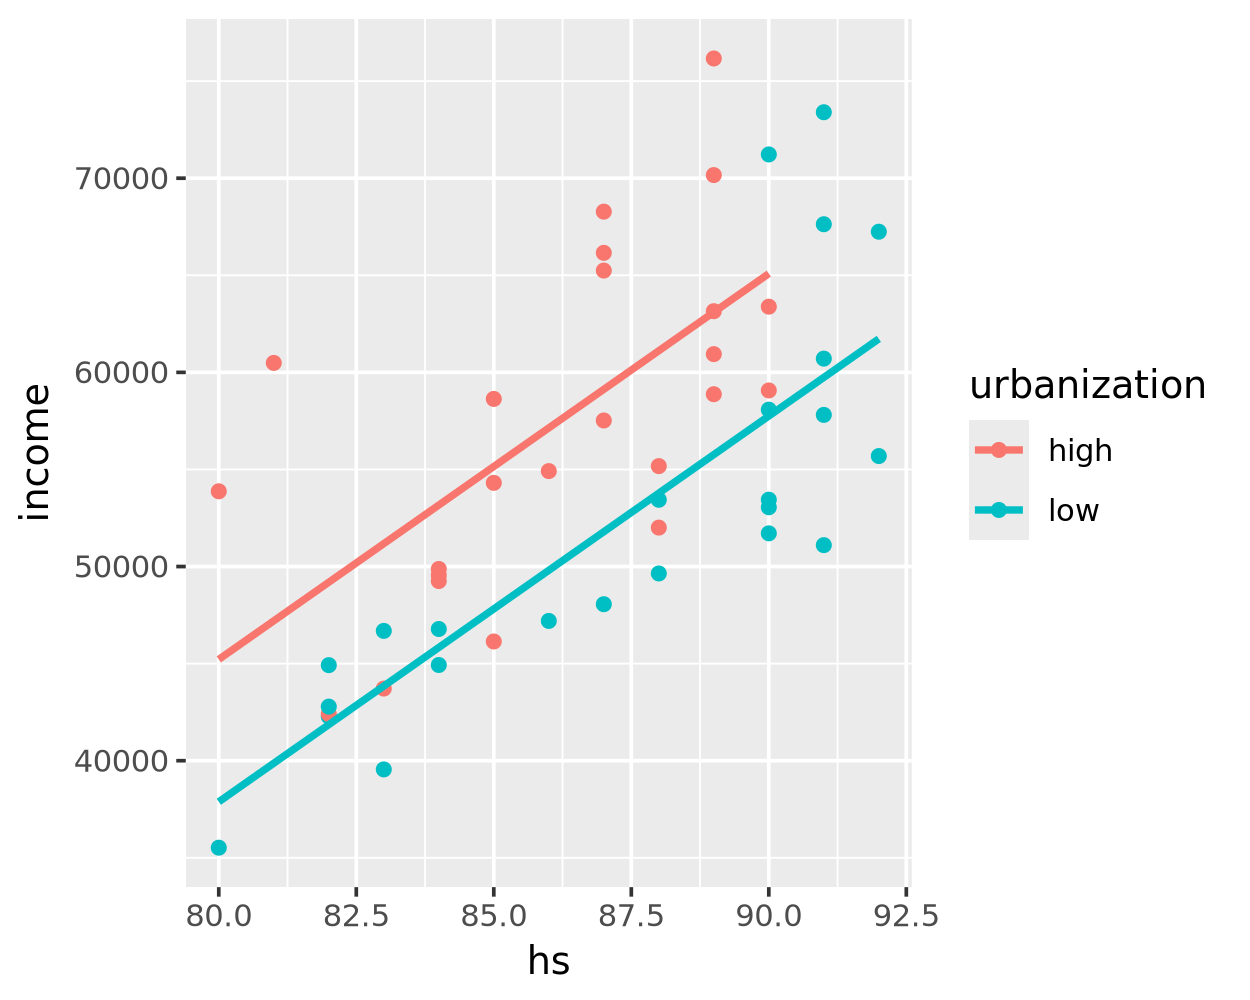

In [9]:
ggplot(hate_crimes, aes(hs, income, color = urbanization)) +
  geom_point() +
  geom_parallel_slopes(se = FALSE)

❓Which regression line (high urbanization or low urbanization) appears to have the larger intercept?

**Answer:**

The high urbanization regression line has the larger intercept.



Now let’s create a second scatterplot using the same variables, but this time draw the regression lines using `geom_smooth(method = "lm")`, which will allow for separate, non-parallel slopes for each urbanization group. 

**Code you your scatter plot in the cell below.**

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


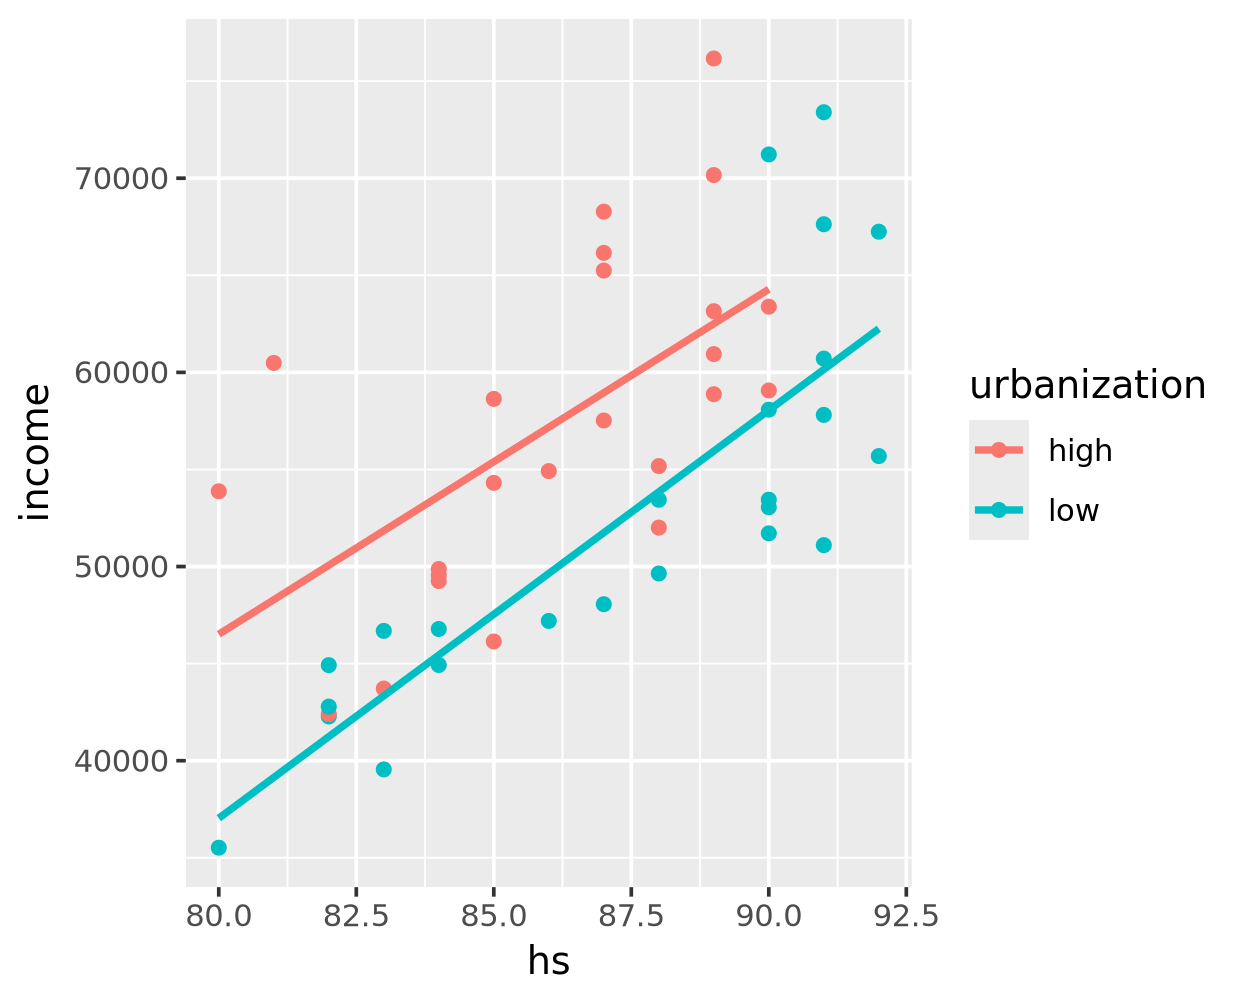

In [10]:
ggplot(hate_crimes, aes(hs, income, color = urbanization)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE)

❓Based on visually comparing the two models shown above, do you think it would be best to run a “parallel slopes” model (i.e. a model that estimates one shared slope for the two levels of urbanization), or a more complex “interaction model” (i.e. a model that estimates a separate slope for the two levels of urbanization)?

**Answer:**

As the regression lines seem to have very similar intercepts and slopes in the interaction and parallel slopes models, it would probably make sense to run the simpler parallel slopes model. The interaction model is probably more accurate than the parallel slopes model, but given the results of the 2 models are very close, it's better to simplify and use the parallel slopes model (thus having to focus only on one slope value).

Fit the following two regression models that examine the relationship between household `income` (as response variable), and high-school education (`hs`) and `urbanization` as explanatory variables:

1. A parallel slopes model (i.e., no interaction between `hs` and `urbanization`). ❗️Save the data recipe and model under the variables `ps_rec` and `ps_mod`, respectively. 
1. A non-parallel slopes model (i.e., allow `hs` and `urbanization` to interact in your model). ❗️Save the data recipe and model under the variable: `nps_rec` and `nps_mod`, respectively.

**Code you your models in the cell below.**

In [25]:
# parallel slopes model

ps_rec = recipe(income ~ hs + urbanization, data = hate_crimes) |> 
    step_naomit(everything()) |>   # remove missing values
    step_dummy(urbanization) |>    # dummy encode the urbanization variable
    prep()                         # run the recipe on the training data provided

mod = linear_reg() |> set_engine('lm')

ps_mod = mod |> fit(income ~ ., juice(ps_rec))

ps_mod

parsnip model object


Call:
stats::lm(formula = income ~ ., data = data)

Coefficients:
     (Intercept)                hs  urbanization_low  
         -113725              1987             -7333  


In [27]:
# non-parallel slopes model

# ❗️ you can use most of the code above, just add step_interact(~ starts_with("urbanization"):hs) to the recipe and
#    switch the variable names...

nps_rec = recipe(income ~ hs + urbanization, data = hate_crimes) |> 
    step_naomit(everything()) |>
    step_dummy(urbanization) |>
    step_interact(~ starts_with("urbanization"):hs) |>
    prep()

mod2 = linear_reg() |> set_engine('lm')

nps_mod = mod2 |> fit(income ~ ., juice(nps_rec))

nps_mod

parsnip model object


Call:
stats::lm(formula = income ~ ., data = data)

Coefficients:
          (Intercept)                     hs       urbanization_low  
               -95647                   1777                 -35394  
urbanization_low_x_hs  
                  324  


The following code creates a table of your model predictions over the training data. Calculate the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) (R<sup>2</sup>) for each model:

```r
rbind(
    augment(ps_mod, juice(ps_rec)) |> select(income, .pred, .resid) |> mutate(model = "parallel_slopes"),
    augment(nps_mod, juice(nps_rec)) |> select(income, .pred, .resid) |> mutate(model = "interaction")
)
```

1. Group rows by the `model` variable (use the `group_by` function).
1. Calculate the variance of income over the variance of your predictions for each model using the "grouped" data from the step above (use `summarize(r_squared = var(.pred) / var(income))`).

In [28]:
augmented_data <- rbind(
    augment(ps_mod, juice(ps_rec)) |> select(income, .pred, .resid) |> mutate(model = "parallel_slopes"),
    augment(nps_mod, juice(nps_rec)) |> select(income, .pred, .resid) |> mutate(model = "interaction")
)

augmented_data

income,.pred,.resid,model
<int>,<dbl>,<dbl>,<chr>
46686,43845.37,2840.63106,parallel_slopes
51710,57752.93,-6042.92572,parallel_slopes
54310,55152.28,-842.28220,parallel_slopes
54916,57139.08,-2223.07603,parallel_slopes
57522,59125.87,-1603.86985,parallel_slopes
58633,55152.28,3480.71780,parallel_slopes
58875,63099.46,-4224.45751,parallel_slopes
59068,65086.25,-6018.25133,parallel_slopes
60487,47205.11,13281.89310,parallel_slopes


In [29]:
augmented_data_summary <- augmented_data %>% 
  group_by(model) %>% 
  summarize(r_squared = var(.pred) / var(income))
augmented_data_summary

model,r_squared
<chr>,<dbl>
interaction,0.5746731
parallel_slopes,0.5716112


🎶 Note: you can also use the `glance` function with a model as input to find the coefficient of determination.

In [30]:
glance(ps_mod)
glance(nps_mod)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.5716112,0.5525717,6325.667,30.02238,5.204241e-09,2,-486.6739,981.3479,988.8327,1800633086,45,48


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.5746731,0.5456735,6374.244,19.81661,2.814509e-08,3,-486.5018,983.0035,992.3595,1787763166,44,48


❓Compare the adjusted proportion of variance accounted for in each model. Based on this comparison, which model do you prefer? Why? 

**Answer:**

The adjusted R-squared under the parallel slopes model (55.3%) is very close to the adjusted R-squared under the interaction model (54.6%). The additional complexity of the interaction model only improves the adjusted R-squared value by approxiumately 70 basis points (i.e. by approximately 0.7 percentage point). This confirms my earlier observation (when I eyeballed the regression lines in the scatterplots under the 2 models) therefore I keep favoring the simpler parallel slopes model.

❓Using your preferred model, based on your regression model parameters (and the data visualizations), is `income` greater in states that have lower or higher levels of `urbanization`? By how much?

**Hint:** use the `tidy` function with your model as input to access the parameters in a nice table.

**Answer:**

In [31]:
tidy(ps_mod)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-113725.193,23552.9187,-4.828497,1.624694e-05
hs,1986.794,272.9303,7.279490,3.930730e-09
urbanization_low,-7333.326,1857.6592,-3.947616,2.744526e-04


Looking at the regression model parameters under my preferred parallel slopes model, the regression line of the states with lower level of urbanization has a $7,333 lower intercept. This suggests that income in general is greater in states with higher level of urbanization. I was also able to observe it from the scatterplot chart of the parallel slopes model (the regression line of the states with higher level of urbanization was above the regression line of the states with lower level of urbanization).

❓For every one percentage point increase of high-school educated adults in a state (`hs` variable), what is the associated average increase in `income`?

**Answer:**

The slope of the regression line under the parallel slopes model is 1,987. This means that for every one percentage point increase of high-school educated adults in a state, there is an associated 1,987 USD increase in income in average.

Under the interaction model, there are obviously different slopes for high income states (1,777) and for low income states (1,777 + 324 = 2,101). This means that for every one percentage point increase of high-school educated adults in a state, there is an associated 1,777 USD and 2,101 USD average income increase in the high income and low income states, respectively.